This lab uses Python in "Notebook" interface. You'll not need to run any code, but you can see examples of how software such as Python can be used to analyse data. Provide answers to questions 1 - 7.

In [289]:
import xarray as xr
import iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import importlib
from dask.distributed import Client

oshome = os.getenv('HOME')
sys.path.append(f'{oshome}/git/RNS_Sydney_1km/plotting_code')
import common_functions as cf
importlib.reload(cf)

datapath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/netcdf'
plotpath = '/g/data/ce10/users/mjl561/cylc-run/rns_ostia_SY_1km/figures'
stationpath = '/g/data/ce10/users/mjl561/observations/AWS/au-2000_2024_5min'
cycle_path = '/scratch/ce10/mjl561/cylc-run/rns_ostia/share/cycle'

local_time = True
local_time_offset = 10

available_variables = [
    'air_temperature', 'surface_temperature', 'relative_humidity',
    'latent_heat_flux', 'sensible_heat_flux', 'ground_heat_flux',
    'surface_net_longwave_flux', 'surface_net_shortwave_flux',
]

try:
    print(client)
except Exception:
    client = Client()

<Client: 'tcp://127.0.0.1:40741' processes=7 threads=7>


In [290]:
exps = ['E5L_1_CCI','BR2_1_CCI_no_urban']
# load land sea mask
lsm = xr.open_dataset(f'{datapath}/land_sea_mask/{exps[0]}_land_sea_mask.nc').isel(time=0)['land_binary_mask']

## Q1
With reference to the figure below, describe how you expect average temperature in this domain to be affected by orography or surface height features?

Text(0.5, 1.0, 'surface height [m]')

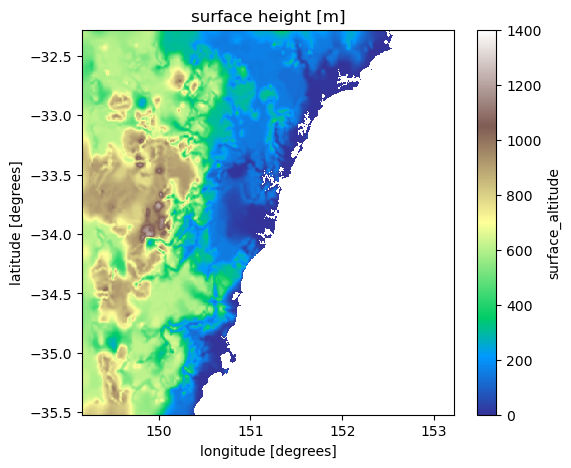

In [291]:
variable = 'surface_altitude'

ds = xr.open_dataset(f'{datapath}/{variable}/{exps[0]}_{variable}.nc')
ds = ds.mean('time')
# keep land points only using land sea mask
ds = ds.where(lsm==1)

fig,ax = plt.subplots(nrows=1,ncols=1,
                        figsize=(6,5),
                        sharey=True)

ds[variable].plot(ax=ax, cmap='terrain', vmin=0, vmax=1400, extend='neither')
ax.set_title('surface height [m]')

## Q2:
How does your description in Q1 compare with the modelled air temperature in the domain? Explain the difference between modelled air temperature in the left and right figures below. What is the name of this phenomenon?

Text(0.5, 0.98, 'mean air temperature at 1.5 m')

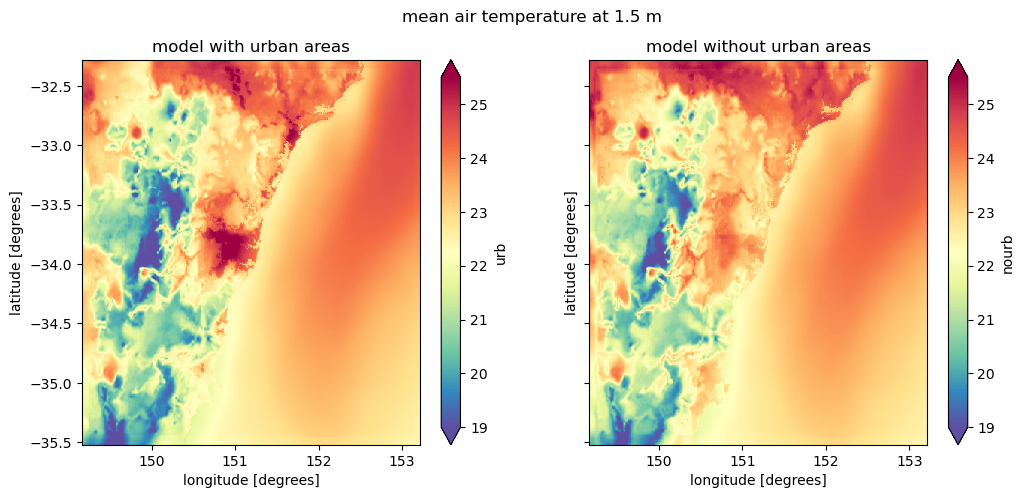

In [292]:
variable = 'air_temperature_1p5m'

# open data
ds = xr.Dataset()
ds['urb'] = xr.open_dataset(f'{datapath}/{variable}/{exps[0]}_{variable}.nc')['air_temperature']
ds['nourb'] = xr.open_dataset(f'{datapath}/{variable}/{exps[1]}_{variable}.nc')['air_temperature']

# # convert to local time and update timezone
ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
ds.time.attrs.update({'timezone': 'AEST'})

# plot figures
fig,axes = plt.subplots(nrows=1,ncols=2,
                        figsize=(12,5),
                        sharey=True)
ds['urb'].mean('time').plot(ax=axes[0], cmap = 'Spectral_r', vmin=19, vmax=25.5)
ds['nourb'].mean('time').plot(ax=axes[1], cmap = 'Spectral_r', vmin=19, vmax=25.5)

axes[0].set_title('model with urban areas')
axes[1].set_title('model without urban areas')
fig.suptitle('mean air temperature at 1.5 m')



## Q3:
We will load data from four Bureau of Meteorology stations, roughly spread from east to west of the city. Looking at satellite images (e.g. using google with the latitude/longitdue listed below), roughly describe the station locations:

    66137: BANKSTOWN AIRPORT AWS: (-33.9176,150.9837)
    66212: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE): (-33.8338,151.0718)
    66196: SYDNEY HARBOUR (WEDDING CAKE WEST): (-33.8405,151.2643)
    67108: BADGERYS CREEK AWS: (-33.8969,150.7281)

In [293]:
# load observations
obs_fname = f'{stationpath}/all_stations_air_temperature_from_2013-01-01.nc'
obs_ds = xr.open_dataset(obs_fname)
station_ids = ['66137','66212','66196','67108']

# get data in simulation period
obs = obs_ds[station_ids].to_dataframe().loc['2017-01']
# select only obs that align with ds model times
obs = obs.loc[ds.time.values]

In [294]:
# print station information
for station in station_ids:
    name = obs_ds[station].station_name
    lat = obs_ds[station].latitude
    lon = obs_ds[station].longitude
    print(f'{station}: {name}: ({lat},{lon})')

66137: BANKSTOWN AIRPORT AWS: (-33.9176,150.9837)
66212: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE): (-33.8338,151.0718)
66196: SYDNEY HARBOUR (WEDDING CAKE WEST): (-33.8405,151.2643)
67108: BADGERYS CREEK AWS: (-33.8969,150.7281)


## Q4:
Now consider the average of the air temperature observations at various locations compared with the simulations. Describe differences and what might be causing these differences. The colour of the observation marker (circle) is based on the values of the colorbar (20°C - 26°C).

Text(0.5, 0.98, 'mean air temperature at 1.5 m')

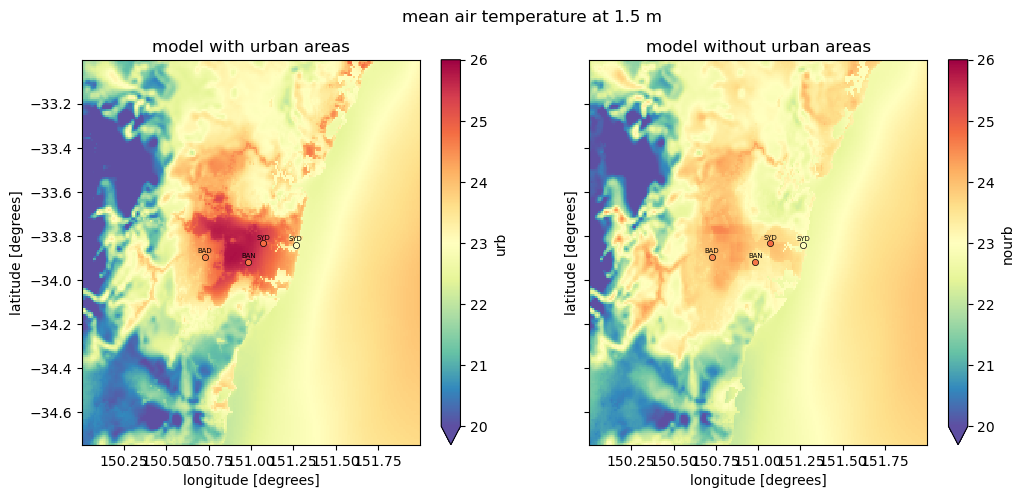

In [295]:
# plot figures
fig,axes = plt.subplots(nrows=1,ncols=2,
                        figsize=(12,5),
                        sharey=True)

for ax, exp in zip(axes.flatten(), ['urb','nourb']):
    subset = ds[exp].sel(latitude=slice(-34.75,-33),longitude=slice(150,152)).mean('time')
    im = subset.plot(ax=ax, cmap = 'Spectral_r', vmin=20, vmax=26)
    # include obsevations
    for station in station_ids:
        name = obs_ds[station].station_name
        lat, lon = obs_ds[station].latitude, obs_ds[station].longitude
        obs_val = obs[station].mean()
        ax.scatter(lon,lat, c=obs_val, norm=im.norm, 
                   cmap=im.cmap, marker='o', s=20, edgecolors='k', linewidth=0.5, zorder=10)
        ax.annotate(text=name[:3], xycoords='data', xy=(lon,lat), xytext=(0,3),
                textcoords='offset points', fontsize=5,color='k',ha='center', zorder=10)
        

axes[0].set_title('model with urban areas')
axes[1].set_title('model without urban areas')
fig.suptitle('mean air temperature at 1.5 m')

## Q5:
Below we plot the diurnal average air temperature at a particular Bureau site: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE). With reference to the spatial and diurnal plots of temperature, which simulation is better matching with observations? Note differences and hypothesise why these differences might occur, considering the Bureau site location and the resolution of the model.

Text(0, 0.5, 'Air temperature [°C]')

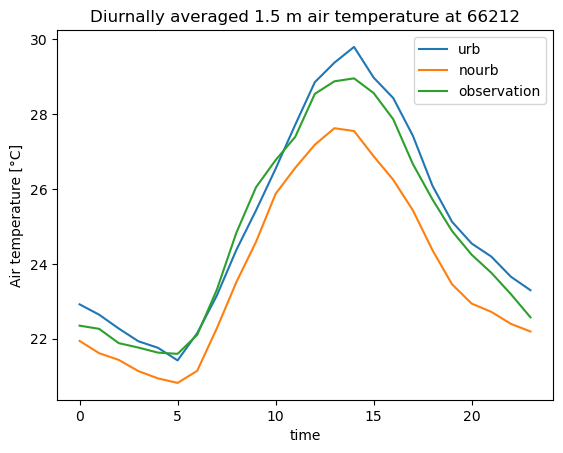

In [296]:
# focus on one location: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE): (-33.8338,151.0718)
station = '66212'
lat, lon = obs_ds[station].latitude, obs_ds[station].longitude
# get simulation data nearest this point
sim_ts = ds.sel(latitude=lat, longitude=lon, method='nearest').to_dataframe()[['urb','nourb']]
# concatenate obs and sim data
df = pd.concat([sim_ts, obs[station]], axis=1)
# rename obs column
df = df.rename(columns={station:'observation'})
# calculate diurnal mean
df_diurnal = df.groupby(df.index.hour).mean()

# plot with observations column in black
df_diurnal.plot()
plt.title(f'Diurnally averaged 1.5 m air temperature at {station}')
plt.ylabel('Air temperature [°C]')

## Q6
We will now compare the surface heat fluxes between the simulation with and without urban representation at a particular Bureau site: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE). Describe the differences in the diurnal plot of surface heat fluxes below. Note that the simulation with an urban representation has solid lines, and the simulation without an urban represenation has dashed lines.

In [305]:
def open_sim_data(exp):

    def open_variable(variable):
        ds = xr.open_dataset(f'{datapath}/{variable}/{exp}_{variable}.nc')
        ds_var = list(ds.keys())[0]
        da = ds[ds_var]
        return da
   
    # open urban data
    ds = xr.Dataset()
    variable = 'surface_net_shortwave_flux'
    ds[variable] = open_variable(variable)
    variable = 'surface_net_longwave_flux'
    ds[variable] = open_variable(variable)
    variable = 'latent_heat_flux'
    ds[variable] = open_variable(variable)
    variable = 'sensible_heat_flux'
    ds[variable] = open_variable(variable)
    variable = 'ground_heat_flux'
    da = open_variable(variable)
    ds[variable] = da.drop_vars('soil_model_level_number')

    ds = ds.assign_coords(time=ds.time + pd.Timedelta(f'{local_time_offset}h'))
    ds.time.attrs.update({'timezone': 'AEST'})

    return ds

urb = open_sim_data(exps[0])
nourb = open_sim_data(exps[1])

In [306]:
# focus on one location: SYDNEY OLYMPIC PARK AWS (ARCHERY CENTRE): (-33.8338,151.0718)
station = '66212'
lat, lon = obs_ds[station].latitude, obs_ds[station].longitude
df_urb = urb.sel(latitude=lat, longitude=lon, method='nearest').to_dataframe().drop(columns=['latitude','longitude'])
df_nourb = nourb.sel(latitude=lat, longitude=lon, method='nearest').to_dataframe().drop(columns=['latitude','longitude'])

In [307]:
df_urb_diurnal = df_urb.groupby(df_urb.index.hour).mean()
df_nourb_diurnal = df_nourb.groupby(df_urb.index.hour).mean()

Text(0.5, 1.0, 'Diurnal fluxes: urban (solid), no urban (dashed)')

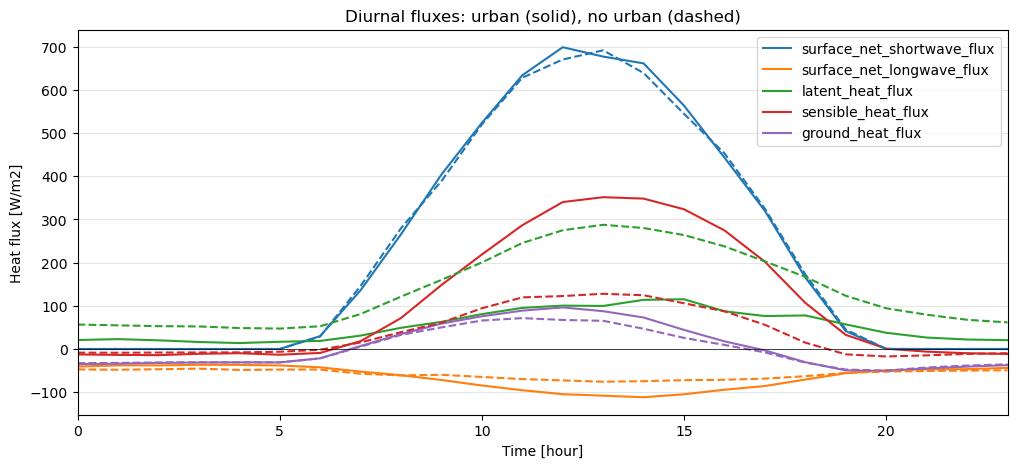

In [308]:
fig,ax = plt.subplots(figsize=(12,5),
                        sharey=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

df_urb_diurnal.plot(ax=ax, ls='solid',color=colors)
df_nourb_diurnal.plot(ax=ax, ls='dashed', color=colors, legend=False)
ax.hlines(y=0,xmin=0,xmax=23, color='k', lw=0.5)
ax.set_xlim(0,23)
ax.grid(axis='y', color='0.9')
ax.set_ylabel('Heat flux [W/m2]')
ax.set_xlabel('Time [hour]')
ax.set_title('Diurnal fluxes: urban (solid), no urban (dashed)')

## Q7: 
What physical processes explain the differences in the average diurnal surface heat fluxes between simulations?